In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA

# Utils

In [2]:
data_dir = "Scenarios"
os.makedirs(data_dir, exist_ok=True)

In [3]:
df = pd.read_csv('../data/heart.csv')

In [4]:
df

Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  \
0     40   M           ATA        140          289          0     Normal   
1     49   F           NAP        160          180          0     Normal   
2     37   M           ATA        130          283          0         ST   
3     48   F           ASY        138          214          0     Normal   
4     54   M           NAP        150          195          0     Normal   
..   ...  ..           ...        ...          ...        ...        ...   
913   45   M            TA        110          264          0     Normal   
914   68   M           ASY        144          193          1     Normal   
915   57   M           ASY        130          131          0     Normal   
916   57   F           ATA        130          236          0        LVH   
917   38   M           NAP        138          175          0     Normal   

     MaxHR ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0      172              N      0.0       Up             0  
1      156              N      1.0     Flat             1  
2       98              N      0.0       Up             0  
3      108              Y      1.5     Flat             1  
4      122              N      0.0       Up             0  
..     ...            ...      ...      ...           ...  
913    132              N      1.2     Flat             1  
914    141              N      3.4     Flat             1  
915    115              Y      1.2     Flat             1  
916    174              N      0.0     Flat             1  
917    173              N      0.0       Up             0  

[918 rows x 12 columns]

In [5]:
category_columns = df.select_dtypes(include=['object']).columns
category_columns

Index(['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], dtype='object')

In [6]:
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns
numerical_features = numerical_features.drop(labels=['HeartDisease', "FastingBS"])
numerical_features

Index(['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak'], dtype='object')

In [7]:
def label_encode(df, columns):
    le = LabelEncoder()
    for column in columns:
        df[column] = le.fit_transform(df[column])
    return df

In [8]:
def apply_scaler(df, scaler):
    columns = df.columns
    columns = columns.drop('HeartDisease')
    df_new = pd.DataFrame(scaler.fit_transform(df.drop(columns='HeartDisease')), columns=columns)
    df_new = pd.concat([df_new, df[['HeartDisease']]], axis=1)
    return df_new

In [9]:
def detect_outliers_IQR(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    outliers = (data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))
    return outliers

In [10]:
def is_blunder(df):
    columns = []
    if df["Cholesterol"].min() <= 0:
        print("Blunder in Cholesterol")
        columns.append("Cholesterol")
    if df["Oldpeak"].min() < 0:
        print("Blunder in Oldpeak")
        columns.append("Oldpeak")
    if df["RestingBP"].min() <= 0:
        print("Blunder in RestingBP")
        columns.append("RestingBP")
    
    return columns

In [11]:
def fix_blunder(df, columns):
    for column in columns:
        if column == "Cholesterol" or column == "RestingBP":
            df[column] = df[column].replace(0, df[column].mean())
        elif column == "Oldpeak":
            df[column] = df[column].apply(lambda x: np.abs(x) if x < 0 else x)
    # Validate if blunder is fixed
    columns = is_blunder(df)
    if len(columns) == 0:
        print("Blunders fixed")
    return df

In [55]:
def plot_pca_scenarios(scenarios, three_d=False):
    for scenario in scenarios:
        df = pd.read_csv(os.path.join(data_dir, scenario))
        X = df.drop(columns='HeartDisease')
        y = df['HeartDisease']
        cmap = sns.color_palette("viridis", as_cmap=True)
        norm = plt.Normalize(vmin=np.min(y), vmax=np.max(y))
        unique_values = np.unique(y)
        colors = [cmap(norm(value)) for value in unique_values]
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X)
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette=colors, ax=axes[0])
        axes[0].set_title(f"PCA 2D for {scenario}")
        
        if three_d:
            ax_3d = fig.add_subplot(122, projection='3d')
            ax_3d.scatter(X_pca[:, 0], X_pca[:, 1], y, c=y, cmap=cmap)
            ax_3d.set_title(f"PCA 3D for {scenario}")
        else:
            fig.delaxes(axes[1])

        plt.tight_layout()
        plt.show()

# Scenario 1

## Scenario 1_N
- Label encoding Categorical Features 
- Not Removing Outliers
- Not Removing Error/blunders in data
- MinMax Scaling

In [12]:
df1 = df.copy()

df1 = label_encode(df1, category_columns)
df1 = apply_scaler(df1, MinMaxScaler())

df1.to_csv(os.path.join(data_dir, "dataset_scenario_1_N.csv"), index=False)
df1

Age  Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  \
0    0.244898  1.0       0.333333       0.70     0.479270        0.0   
1    0.428571  0.0       0.666667       0.80     0.298507        0.0   
2    0.183673  1.0       0.333333       0.65     0.469320        0.0   
3    0.408163  0.0       0.000000       0.69     0.354892        0.0   
4    0.530612  1.0       0.666667       0.75     0.323383        0.0   
..        ...  ...            ...        ...          ...        ...   
913  0.346939  1.0       1.000000       0.55     0.437811        0.0   
914  0.816327  1.0       0.000000       0.72     0.320066        1.0   
915  0.591837  1.0       0.000000       0.65     0.217247        0.0   
916  0.591837  0.0       0.333333       0.65     0.391376        0.0   
917  0.204082  1.0       0.666667       0.69     0.290216        0.0   

     RestingECG     MaxHR  ExerciseAngina   Oldpeak  ST_Slope  HeartDisease  
0           0.5  0.788732             0.0  0.295455       1.0             0  
1           0.5  0.676056             0.0  0.409091       0.5             1  
2           1.0  0.267606             0.0  0.295455       1.0             0  
3           0.5  0.338028             1.0  0.465909       0.5             1  
4           0.5  0.436620             0.0  0.295455       1.0             0  
..          ...       ...             ...       ...       ...           ...  
913         0.5  0.507042             0.0  0.431818       0.5             1  
914         0.5  0.570423             0.0  0.681818       0.5             1  
915         0.5  0.387324             1.0  0.431818       0.5             1  
916         0.0  0.802817             0.0  0.295455       0.5             1  
917         0.5  0.795775             0.0  0.295455       1.0             0  

[918 rows x 12 columns]

## Scenario 1_S
- Same as Scenario 1_N but with Standard Scaling

In [13]:
df2 = df.copy()

df2 = label_encode(df2, category_columns)
df2 = apply_scaler(df2, StandardScaler())

df2.to_csv(os.path.join(data_dir, "dataset_scenario_1_S.csv"), index=False)
df2

Age       Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  \
0   -1.433140  0.515952       0.229032   0.410909     0.825070  -0.551341   
1   -0.478484 -1.938163       1.275059   1.491752    -0.171961  -0.551341   
2   -1.751359  0.515952       0.229032  -0.129513     0.770188  -0.551341   
3   -0.584556 -1.938163      -0.816995   0.302825     0.139040  -0.551341   
4    0.051881  0.515952       1.275059   0.951331    -0.034755  -0.551341   
..        ...       ...            ...        ...          ...        ...   
913 -0.902775  0.515952       2.321086  -1.210356     0.596393  -0.551341   
914  1.536902  0.515952      -0.816995   0.627078    -0.053049   1.813758   
915  0.370100  0.515952      -0.816995  -0.129513    -0.620168  -0.551341   
916  0.370100 -1.938163       0.229032  -0.129513     0.340275  -0.551341   
917 -1.645286  0.515952       1.275059   0.302825    -0.217696  -0.551341   

     RestingECG     MaxHR  ExerciseAngina   Oldpeak  ST_Slope  HeartDisease  
0      0.017255  1.382928       -0.823556 -0.832432  1.052114             0  
1      0.017255  0.754157       -0.823556  0.105664 -0.596078             1  
2      1.601219 -1.525138       -0.823556 -0.832432  1.052114             0  
3      0.017255 -1.132156        1.214246  0.574711 -0.596078             1  
4      0.017255 -0.581981       -0.823556 -0.832432  1.052114             0  
..          ...       ...             ...       ...       ...           ...  
913    0.017255 -0.188999       -0.823556  0.293283 -0.596078             1  
914    0.017255  0.164684       -0.823556  2.357094 -0.596078             1  
915    0.017255 -0.857069        1.214246  0.293283 -0.596078             1  
916   -1.566710  1.461525       -0.823556 -0.832432 -0.596078             1  
917    0.017255  1.422226       -0.823556 -0.832432  1.052114             0  

[918 rows x 12 columns]

# Scenario 2

## Scenario 2_N
- Same label encoding as Scenario 1 
- Not Removing Outliers
- Replacing 0 with `RestingBP` with mean value
- Replacing 0 with `Cholesterol` with mean value
- Taking absolute value of `Oldpeak`negative values
- MinMax Scaling

In [14]:
df3 = df.copy()

blunder_columns = is_blunder(df3)
df3 = fix_blunder(df3, blunder_columns)

df3 = label_encode(df3, category_columns)
df3 = apply_scaler(df3, MinMaxScaler())

df3.to_csv(os.path.join(data_dir, "dataset_scenario_2_N.csv"), index=False)
df3

Blunder in Cholesterol
Blunder in Oldpeak
Blunder in RestingBP
Blunders fixed


Age  Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  \
0    0.244898  1.0       0.333333   0.500000     0.393822        0.0   
1    0.428571  0.0       0.666667   0.666667     0.183398        0.0   
2    0.183673  1.0       0.333333   0.416667     0.382239        0.0   
3    0.408163  0.0       0.000000   0.483333     0.249035        0.0   
4    0.530612  1.0       0.666667   0.583333     0.212355        0.0   
..        ...  ...            ...        ...          ...        ...   
913  0.346939  1.0       1.000000   0.250000     0.345560        0.0   
914  0.816327  1.0       0.000000   0.533333     0.208494        1.0   
915  0.591837  1.0       0.000000   0.416667     0.088803        0.0   
916  0.591837  0.0       0.333333   0.416667     0.291506        0.0   
917  0.204082  1.0       0.666667   0.483333     0.173745        0.0   

     RestingECG     MaxHR  ExerciseAngina   Oldpeak  ST_Slope  HeartDisease  
0           0.5  0.788732             0.0  0.000000       1.0             0  
1           0.5  0.676056             0.0  0.161290       0.5             1  
2           1.0  0.267606             0.0  0.000000       1.0             0  
3           0.5  0.338028             1.0  0.241935       0.5             1  
4           0.5  0.436620             0.0  0.000000       1.0             0  
..          ...       ...             ...       ...       ...           ...  
913         0.5  0.507042             0.0  0.193548       0.5             1  
914         0.5  0.570423             0.0  0.548387       0.5             1  
915         0.5  0.387324             1.0  0.193548       0.5             1  
916         0.0  0.802817             0.0  0.000000       0.5             1  
917         0.5  0.795775             0.0  0.000000       1.0             0  

[918 rows x 12 columns]

## Scenario 2_S
- Same as Scenario 2_N but with Standard Scaling

In [15]:
df4 = df.copy()

blunder_columns = is_blunder(df4)
df4 = fix_blunder(df4, blunder_columns)

df4 = label_encode(df4, category_columns)
df4 = apply_scaler(df4, StandardScaler())
df4.to_csv(os.path.join(data_dir, "dataset_scenario_2_S.csv"), index=False)

df4

Blunder in Cholesterol
Blunder in Oldpeak
Blunder in RestingBP
Blunders fixed


Age       Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  \
0   -1.433140  0.515952       0.229032   0.414861     0.942044  -0.551341   
1   -0.478484 -1.938163       1.275059   1.527200    -0.997102  -0.551341   
2   -1.751359  0.515952       0.229032  -0.141308     0.835302  -0.551341   
3   -0.584556 -1.938163      -0.816995   0.303628    -0.392231  -0.551341   
4    0.051881  0.515952       1.275059   0.971031    -0.730247  -0.551341   
..        ...       ...            ...        ...          ...        ...   
913 -0.902775  0.515952       2.321086  -1.253647     0.497286  -0.551341   
914  1.536902  0.515952      -0.816995   0.637329    -0.765828   1.813758   
915  0.370100  0.515952      -0.816995  -0.141308    -1.868828  -0.551341   
916  0.370100 -1.938163       0.229032  -0.141308    -0.000843  -0.551341   
917 -1.645286  0.515952       1.275059   0.303628    -1.086054  -0.551341   

     RestingECG     MaxHR  ExerciseAngina   Oldpeak  ST_Slope  HeartDisease  
0      0.017255  1.382928       -0.823556 -0.878238  1.052114             0  
1      0.017255  0.754157       -0.823556  0.081322 -0.596078             1  
2      1.601219 -1.525138       -0.823556 -0.878238  1.052114             0  
3      0.017255 -1.132156        1.214246  0.561102 -0.596078             1  
4      0.017255 -0.581981       -0.823556 -0.878238  1.052114             0  
..          ...       ...             ...       ...       ...           ...  
913    0.017255 -0.188999       -0.823556  0.273234 -0.596078             1  
914    0.017255  0.164684       -0.823556  2.384267 -0.596078             1  
915    0.017255 -0.857069        1.214246  0.273234 -0.596078             1  
916   -1.566710  1.461525       -0.823556 -0.878238 -0.596078             1  
917    0.017255  1.422226       -0.823556 -0.878238  1.052114             0  

[918 rows x 12 columns]

# Scenario 3

## Scenario 3_N
- Same label encoding as Scenario 1
- Removing Outliers
- Checking for Error/blunders in data after removing outliers

In [16]:
df5 = df.copy()

outliers = {}

for col in numerical_features:
    outliers[col] = detect_outliers_IQR(df5[col])
    print(f"Outliers in {col} are {outliers[col].sum()}")

outlier_mask = pd.Series(True, index=df5.index)
for col in numerical_features:
    outlier_mask &= ~outliers[col].reindex(df5.index, fill_value=False)

print(f"Total outliers removed: {outlier_mask.sum()}")

df5 = df5[outlier_mask]

df5.reset_index(drop=True, inplace=True)

blunder_columns = is_blunder(df5)

df5 = fix_blunder(df5, blunder_columns) # if no blunders then it will return the same dataframe

df5 = label_encode(df5, category_columns)
df5 = apply_scaler(df5, MinMaxScaler())
df5.to_csv(os.path.join(data_dir, "dataset_scenario_3_N.csv"), index=False)

df5

Outliers in Age are 0
Outliers in RestingBP are 28
Outliers in Cholesterol are 183
Outliers in MaxHR are 2
Outliers in Oldpeak are 16
Total outliers removed: 702
Blunder in Oldpeak
Blunders fixed


Age  Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  \
0    0.244898  1.0       0.333333   0.615385     0.639498        0.0   
1    0.428571  0.0       0.666667   0.871795     0.297806        0.0   
2    0.183673  1.0       0.333333   0.487179     0.620690        0.0   
3    0.408163  0.0       0.000000   0.589744     0.404389        0.0   
4    0.530612  1.0       0.666667   0.743590     0.344828        0.0   
..        ...  ...            ...        ...          ...        ...   
697  0.346939  1.0       1.000000   0.230769     0.561129        0.0   
698  0.816327  1.0       0.000000   0.666667     0.338558        1.0   
699  0.591837  1.0       0.000000   0.487179     0.144201        0.0   
700  0.591837  0.0       0.333333   0.487179     0.473354        0.0   
701  0.204082  1.0       0.666667   0.589744     0.282132        0.0   

     RestingECG     MaxHR  ExerciseAngina   Oldpeak  ST_Slope  HeartDisease  
0           0.5  0.770992             0.0  0.000000       1.0             0  
1           0.5  0.648855             0.0  0.277778       0.5             1  
2           1.0  0.206107             0.0  0.000000       1.0             0  
3           0.5  0.282443             1.0  0.416667       0.5             1  
4           0.5  0.389313             0.0  0.000000       1.0             0  
..          ...       ...             ...       ...       ...           ...  
697         0.5  0.465649             0.0  0.333333       0.5             1  
698         0.5  0.534351             0.0  0.944444       0.5             1  
699         0.5  0.335878             1.0  0.333333       0.5             1  
700         0.0  0.786260             0.0  0.000000       0.5             1  
701         0.5  0.778626             0.0  0.000000       1.0             0  

[702 rows x 12 columns]

## Scenario 3_S
- Same as Scenario 3_N but with Standard Scaling

In [17]:
df6 = df.copy()

outliers = {}

for col in numerical_features:
    outliers[col] = detect_outliers_IQR(df6[col])
    print(f"Outliers in {col} are {outliers[col].sum()}")

outlier_mask = pd.Series(True, index=df6.index)
for col in numerical_features:
    outlier_mask &= ~outliers[col].reindex(df6.index, fill_value=False)

print(f"Total outliers removed: {outlier_mask.sum()}")

df6 = df6[outlier_mask]
    
df6.reset_index(drop=True, inplace=True)

blunder_columns = is_blunder(df6)

df6 = fix_blunder(df6, blunder_columns) # if no blunders then it will return the same dataframe

df6 = label_encode(df6, category_columns)
df6 = apply_scaler(df6, StandardScaler())
df6.to_csv(os.path.join(data_dir, "dataset_scenario_3_S.csv"), index=False)

df6

Outliers in Age are 0
Outliers in RestingBP are 28
Outliers in Cholesterol are 183
Outliers in MaxHR are 2
Outliers in Oldpeak are 16
Total outliers removed: 702
Blunder in Oldpeak
Blunders fixed


Age       Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  \
0   -1.335169  0.560898       0.147121   0.547914     0.973199  -0.440315   
1   -0.390639 -1.782855       1.190340   1.845825    -1.178909  -0.440315   
2   -1.650013  0.560898       0.147121  -0.101041     0.854735  -0.440315   
3   -0.495587 -1.782855      -0.896099   0.418123    -0.507609  -0.440315   
4    0.134100  0.560898       1.190340   1.196870    -0.882748  -0.440315   
..        ...       ...            ...        ...          ...        ...   
697 -0.810430  0.560898       2.233560  -1.398952     0.479596  -0.440315   
698  1.603369  0.560898      -0.896099   0.807496    -0.922236   2.271100   
699  0.448943  0.560898      -0.896099  -0.101041    -2.146371  -0.440315   
700  0.448943 -1.782855       0.147121  -0.101041    -0.073239  -0.440315   
701 -1.545065  0.560898       1.190340   0.418123    -1.277630  -0.440315   

     RestingECG     MaxHR  ExerciseAngina   Oldpeak  ST_Slope  HeartDisease  
0      0.113502  1.291925       -0.774008 -0.866913  0.971639             0  
1      0.113502  0.634669       -0.774008  0.176057 -0.750812             1  
2      1.707064 -1.747885       -0.774008 -0.866913  0.971639             0  
3      0.113502 -1.337100        1.291976  0.697542 -0.750812             1  
4      0.113502 -0.762001       -0.774008 -0.866913  0.971639             0  
..          ...       ...             ...       ...       ...           ...  
697    0.113502 -0.351215       -0.774008  0.384651 -0.750812             1  
698    0.113502  0.018491       -0.774008  2.679186 -0.750812             1  
699    0.113502 -1.049550        1.291976  0.384651 -0.750812             1  
700   -1.480061  1.374082       -0.774008 -0.866913 -0.750812             1  
701    0.113502  1.333004       -0.774008 -0.866913  0.971639             0  

[702 rows x 12 columns]

# Scenario 4

## Scenario 4_N
- Same label encoding as Scenario 1
- Removing Outliers by replacing with mean value
- Checking for Error/blunders in data after removing outliers
- MinMax Scaling

In [18]:
df7 = df.copy()
outliers = {}

for col in numerical_features:
    outliers[col] = detect_outliers_IQR(df7[col])
    print(f"Outliers in {col} are {outliers[col].sum()}")

for col in numerical_features:
    df7[col] = df7[col].mask(outliers[col], df7[col].mean())

print("Replacing outliers with mean")
    
blunder_columns = is_blunder(df7)

df7 = fix_blunder(df7, blunder_columns) # if no blunders then it will return the same dataframe

df7 = label_encode(df7, category_columns)
df7 = apply_scaler(df7, MinMaxScaler())
df7.to_csv(os.path.join(data_dir, "dataset_scenario_4_N.csv"), index=False)

df7

Outliers in Age are 0
Outliers in RestingBP are 28
Outliers in Cholesterol are 183
Outliers in MaxHR are 2
Outliers in Oldpeak are 16
Replacing outliers with mean
Blunder in Oldpeak
Blunders fixed


Age  Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  \
0    0.244898  1.0       0.333333   0.615385     0.633540        0.0   
1    0.428571  0.0       0.666667   0.871795     0.295031        0.0   
2    0.183673  1.0       0.333333   0.487179     0.614907        0.0   
3    0.408163  0.0       0.000000   0.589744     0.400621        0.0   
4    0.530612  1.0       0.666667   0.743590     0.341615        0.0   
..        ...  ...            ...        ...          ...        ...   
913  0.346939  1.0       1.000000   0.230769     0.555901        0.0   
914  0.816327  1.0       0.000000   0.666667     0.335404        1.0   
915  0.591837  1.0       0.000000   0.487179     0.142857        0.0   
916  0.591837  0.0       0.333333   0.487179     0.468944        0.0   
917  0.204082  1.0       0.666667   0.589744     0.279503        0.0   

     RestingECG     MaxHR  ExerciseAngina   Oldpeak  ST_Slope  HeartDisease  
0           0.5  0.777778             0.0  0.000000       1.0             0  
1           0.5  0.659259             0.0  0.270270       0.5             1  
2           1.0  0.229630             0.0  0.000000       1.0             0  
3           0.5  0.303704             1.0  0.405405       0.5             1  
4           0.5  0.407407             0.0  0.000000       1.0             0  
..          ...       ...             ...       ...       ...           ...  
913         0.5  0.481481             0.0  0.324324       0.5             1  
914         0.5  0.548148             0.0  0.918919       0.5             1  
915         0.5  0.355556             1.0  0.324324       0.5             1  
916         0.0  0.792593             0.0  0.000000       0.5             1  
917         0.5  0.785185             0.0  0.000000       1.0             0  

[918 rows x 12 columns]

## Scenario 4_S
- Same as Scenario 4_N but with Standard Scaling

In [19]:
df8 = df.copy()
outliers = {}

for col in numerical_features:
    outliers[col] = detect_outliers_IQR(df8[col])
    print(f"Outliers in {col} are {outliers[col].sum()}")

for col in numerical_features:
    df8[col] = df8[col].mask(outliers[col], df8[col].mean())

print("Replacing outliers with mean")
    
blunder_columns = is_blunder(df8)

df8 = fix_blunder(df8, blunder_columns) # if no blunders then it will return the same dataframe

df8 = label_encode(df8, category_columns)
df8 = apply_scaler(df8, StandardScaler())
df8.to_csv(os.path.join(data_dir, "dataset_scenario_4_S.csv"), index=False)

df8

Outliers in Age are 0
Outliers in RestingBP are 28
Outliers in Cholesterol are 183
Outliers in MaxHR are 2
Outliers in Oldpeak are 16
Replacing outliers with mean
Blunder in Oldpeak
Blunders fixed


Age       Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  \
0   -1.433140  0.515952       0.229032   0.567537     1.156234  -0.551341   
1   -0.478484 -1.938163       1.275059   1.850485    -1.079045  -0.551341   
2   -1.751359  0.515952       0.229032  -0.073937     1.033191  -0.551341   
3   -0.584556 -1.938163      -0.816995   0.439242    -0.381802  -0.551341   
4    0.051881  0.515952       1.275059   1.209011    -0.771438  -0.551341   
..        ...       ...            ...        ...          ...        ...   
913 -0.902775  0.515952       2.321086  -1.356886     0.643555  -0.551341   
914  1.536902  0.515952      -0.816995   0.824126    -0.812452   1.813758   
915  0.370100  0.515952      -0.816995  -0.073937    -2.083895  -0.551341   
916  0.370100 -1.938163       0.229032  -0.073937     0.069355  -0.551341   
917 -1.645286  0.515952       1.275059   0.439242    -1.181581  -0.551341   

     RestingECG     MaxHR  ExerciseAngina   Oldpeak  ST_Slope  HeartDisease  
0      0.017255  1.389839       -0.823556 -0.914057  1.052114             0  
1      0.017255  0.754966       -0.823556  0.152966 -0.596078             1  
2      1.601219 -1.546450       -0.823556 -0.914057  1.052114             0  
3      0.017255 -1.149654        1.214246  0.686477 -0.596078             1  
4      0.017255 -0.594140       -0.823556 -0.914057  1.052114             0  
..          ...       ...             ...       ...       ...           ...  
913    0.017255 -0.197344       -0.823556  0.366370 -0.596078             1  
914    0.017255  0.159772       -0.823556  2.713821 -0.596078             1  
915    0.017255 -0.871897        1.214246  0.366370 -0.596078             1  
916   -1.566710  1.469199       -0.823556 -0.914057 -0.596078             1  
917    0.017255  1.429519       -0.823556 -0.914057  1.052114             0  

[918 rows x 12 columns]

# Scenario 5

## Scenario 5_N
- label encoding `Sex`, `ExerciseAngina`, `ST_Slope`, `RestingECG`
- OneHot encoding `ChestPainType`
- Not Removing Outliers
- Not Removing Error/blunders in data
- MinMax Scaling

In [20]:
df9 = df.copy()

df9 = label_encode(df9, category_columns.drop(labels='ChestPainType'))
df9 = pd.get_dummies(df9, columns=['ChestPainType'], dtype=int)

df9 = apply_scaler(df9, MinMaxScaler())
df9.to_csv(os.path.join(data_dir, "dataset_scenario_5_N.csv"), index=False)

df9


Age  Sex  RestingBP  Cholesterol  FastingBS  RestingECG     MaxHR  \
0    0.244898  1.0       0.70     0.479270        0.0         0.5  0.788732   
1    0.428571  0.0       0.80     0.298507        0.0         0.5  0.676056   
2    0.183673  1.0       0.65     0.469320        0.0         1.0  0.267606   
3    0.408163  0.0       0.69     0.354892        0.0         0.5  0.338028   
4    0.530612  1.0       0.75     0.323383        0.0         0.5  0.436620   
..        ...  ...        ...          ...        ...         ...       ...   
913  0.346939  1.0       0.55     0.437811        0.0         0.5  0.507042   
914  0.816327  1.0       0.72     0.320066        1.0         0.5  0.570423   
915  0.591837  1.0       0.65     0.217247        0.0         0.5  0.387324   
916  0.591837  0.0       0.65     0.391376        0.0         0.0  0.802817   
917  0.204082  1.0       0.69     0.290216        0.0         0.5  0.795775   

     ExerciseAngina   Oldpeak  ST_Slope  ChestPainType_ASY  ChestPainType_ATA  \
0               0.0  0.295455       1.0                0.0                1.0   
1               0.0  0.409091       0.5                0.0                0.0   
2               0.0  0.295455       1.0                0.0                1.0   
3               1.0  0.465909       0.5                1.0                0.0   
4               0.0  0.295455       1.0                0.0                0.0   
..              ...       ...       ...                ...                ...   
913             0.0  0.431818       0.5                0.0                0.0   
914             0.0  0.681818       0.5                1.0                0.0   
915             1.0  0.431818       0.5                1.0                0.0   
916             0.0  0.295455       0.5                0.0                1.0   
917             0.0  0.295455       1.0                0.0                0.0   

     ChestPainType_NAP  ChestPainType_TA  HeartDisease  
0                  0.0               0.0             0  
1                  1.0               0.0             1  
2                  0.0               0.0             0  
3                  0.0               0.0             1  
4                  1.0               0.0             0  
..                 ...               ...           ...  
913                0.0               1.0             1  
914                0.0               0.0             1  
915                0.0               0.0             1  
916                0.0               0.0             1  
917                1.0               0.0             0  

[918 rows x 15 columns]

## Scenario 5_S
- Same as Scenario 5_N but with Standard Scaling

In [21]:
df10 = df.copy()

df10 = label_encode(df10, category_columns.drop(labels='ChestPainType'))
df10 = pd.get_dummies(df10, columns=['ChestPainType'], dtype=int)

df10 = apply_scaler(df10, StandardScaler())
df10.to_csv(os.path.join(data_dir, "dataset_scenario_5_S.csv"), index=False)

df10


Age       Sex  RestingBP  Cholesterol  FastingBS  RestingECG  \
0   -1.433140  0.515952   0.410909     0.825070  -0.551341    0.017255   
1   -0.478484 -1.938163   1.491752    -0.171961  -0.551341    0.017255   
2   -1.751359  0.515952  -0.129513     0.770188  -0.551341    1.601219   
3   -0.584556 -1.938163   0.302825     0.139040  -0.551341    0.017255   
4    0.051881  0.515952   0.951331    -0.034755  -0.551341    0.017255   
..        ...       ...        ...          ...        ...         ...   
913 -0.902775  0.515952  -1.210356     0.596393  -0.551341    0.017255   
914  1.536902  0.515952   0.627078    -0.053049   1.813758    0.017255   
915  0.370100  0.515952  -0.129513    -0.620168  -0.551341    0.017255   
916  0.370100 -1.938163  -0.129513     0.340275  -0.551341   -1.566710   
917 -1.645286  0.515952   0.302825    -0.217696  -0.551341    0.017255   

        MaxHR  ExerciseAngina   Oldpeak  ST_Slope  ChestPainType_ASY  \
0    1.382928       -0.823556 -0.832432  1.052114          -1.084138   
1    0.754157       -0.823556  0.105664 -0.596078          -1.084138   
2   -1.525138       -0.823556 -0.832432  1.052114          -1.084138   
3   -1.132156        1.214246  0.574711 -0.596078           0.922392   
4   -0.581981       -0.823556 -0.832432  1.052114          -1.084138   
..        ...             ...       ...       ...                ...   
913 -0.188999       -0.823556  0.293283 -0.596078          -1.084138   
914  0.164684       -0.823556  2.357094 -0.596078           0.922392   
915 -0.857069        1.214246  0.293283 -0.596078           0.922392   
916  1.461525       -0.823556 -0.832432 -0.596078          -1.084138   
917  1.422226       -0.823556 -0.832432  1.052114          -1.084138   

     ChestPainType_ATA  ChestPainType_NAP  ChestPainType_TA  HeartDisease  
0             2.075177          -0.532838         -0.229679             0  
1            -0.481887           1.876744         -0.229679             1  
2             2.075177          -0.532838         -0.229679             0  
3            -0.481887          -0.532838         -0.229679             1  
4            -0.481887           1.876744         -0.229679             0  
..                 ...                ...               ...           ...  
913          -0.481887          -0.532838          4.353909             1  
914          -0.481887          -0.532838         -0.229679             1  
915          -0.481887          -0.532838         -0.229679             1  
916           2.075177          -0.532838         -0.229679             1  
917          -0.481887           1.876744         -0.229679             0  

[918 rows x 15 columns]

# Scenario 6

## Scenatio 6_N
- Same Encoding as Scenario 5
- Removing Blunders/Error in data
- Not Removing Outliers

In [22]:
df11 = df.copy()

df11 = label_encode(df11, category_columns.drop(labels='ChestPainType'))
df11 = pd.get_dummies(df11, columns=['ChestPainType'], dtype=int)

blunder_columns = is_blunder(df11)
df11 = fix_blunder(df11, blunder_columns)

df11 = apply_scaler(df11, MinMaxScaler())
df11.to_csv(os.path.join(data_dir, "dataset_scenario_6_N.csv"), index=False)

df11

Blunder in Cholesterol
Blunder in Oldpeak
Blunder in RestingBP
Blunders fixed


Age  Sex  RestingBP  Cholesterol  FastingBS  RestingECG     MaxHR  \
0    0.244898  1.0   0.500000     0.393822        0.0         0.5  0.788732   
1    0.428571  0.0   0.666667     0.183398        0.0         0.5  0.676056   
2    0.183673  1.0   0.416667     0.382239        0.0         1.0  0.267606   
3    0.408163  0.0   0.483333     0.249035        0.0         0.5  0.338028   
4    0.530612  1.0   0.583333     0.212355        0.0         0.5  0.436620   
..        ...  ...        ...          ...        ...         ...       ...   
913  0.346939  1.0   0.250000     0.345560        0.0         0.5  0.507042   
914  0.816327  1.0   0.533333     0.208494        1.0         0.5  0.570423   
915  0.591837  1.0   0.416667     0.088803        0.0         0.5  0.387324   
916  0.591837  0.0   0.416667     0.291506        0.0         0.0  0.802817   
917  0.204082  1.0   0.483333     0.173745        0.0         0.5  0.795775   

     ExerciseAngina   Oldpeak  ST_Slope  ChestPainType_ASY  ChestPainType_ATA  \
0               0.0  0.000000       1.0                0.0                1.0   
1               0.0  0.161290       0.5                0.0                0.0   
2               0.0  0.000000       1.0                0.0                1.0   
3               1.0  0.241935       0.5                1.0                0.0   
4               0.0  0.000000       1.0                0.0                0.0   
..              ...       ...       ...                ...                ...   
913             0.0  0.193548       0.5                0.0                0.0   
914             0.0  0.548387       0.5                1.0                0.0   
915             1.0  0.193548       0.5                1.0                0.0   
916             0.0  0.000000       0.5                0.0                1.0   
917             0.0  0.000000       1.0                0.0                0.0   

     ChestPainType_NAP  ChestPainType_TA  HeartDisease  
0                  0.0               0.0             0  
1                  1.0               0.0             1  
2                  0.0               0.0             0  
3                  0.0               0.0             1  
4                  1.0               0.0             0  
..                 ...               ...           ...  
913                0.0               1.0             1  
914                0.0               0.0             1  
915                0.0               0.0             1  
916                0.0               0.0             1  
917                1.0               0.0             0  

[918 rows x 15 columns]

## Scenario 6_S
- Same as Scenario 6_N but with Standard Scaling

In [23]:
df12 = df.copy()

df12 = label_encode(df12, category_columns.drop(labels='ChestPainType'))
df12 = pd.get_dummies(df12, columns=['ChestPainType'], dtype=int)

blunder_columns = is_blunder(df12)
df12 = fix_blunder(df12, blunder_columns)

df12 = apply_scaler(df12, StandardScaler())
df12.to_csv(os.path.join(data_dir, "dataset_scenario_6_S.csv"), index=False)

df12

Blunder in Cholesterol
Blunder in Oldpeak
Blunder in RestingBP
Blunders fixed


Age       Sex  RestingBP  Cholesterol  FastingBS  RestingECG  \
0   -1.433140  0.515952   0.414861     0.942044  -0.551341    0.017255   
1   -0.478484 -1.938163   1.527200    -0.997102  -0.551341    0.017255   
2   -1.751359  0.515952  -0.141308     0.835302  -0.551341    1.601219   
3   -0.584556 -1.938163   0.303628    -0.392231  -0.551341    0.017255   
4    0.051881  0.515952   0.971031    -0.730247  -0.551341    0.017255   
..        ...       ...        ...          ...        ...         ...   
913 -0.902775  0.515952  -1.253647     0.497286  -0.551341    0.017255   
914  1.536902  0.515952   0.637329    -0.765828   1.813758    0.017255   
915  0.370100  0.515952  -0.141308    -1.868828  -0.551341    0.017255   
916  0.370100 -1.938163  -0.141308    -0.000843  -0.551341   -1.566710   
917 -1.645286  0.515952   0.303628    -1.086054  -0.551341    0.017255   

        MaxHR  ExerciseAngina   Oldpeak  ST_Slope  ChestPainType_ASY  \
0    1.382928       -0.823556 -0.878238  1.052114          -1.084138   
1    0.754157       -0.823556  0.081322 -0.596078          -1.084138   
2   -1.525138       -0.823556 -0.878238  1.052114          -1.084138   
3   -1.132156        1.214246  0.561102 -0.596078           0.922392   
4   -0.581981       -0.823556 -0.878238  1.052114          -1.084138   
..        ...             ...       ...       ...                ...   
913 -0.188999       -0.823556  0.273234 -0.596078          -1.084138   
914  0.164684       -0.823556  2.384267 -0.596078           0.922392   
915 -0.857069        1.214246  0.273234 -0.596078           0.922392   
916  1.461525       -0.823556 -0.878238 -0.596078          -1.084138   
917  1.422226       -0.823556 -0.878238  1.052114          -1.084138   

     ChestPainType_ATA  ChestPainType_NAP  ChestPainType_TA  HeartDisease  
0             2.075177          -0.532838         -0.229679             0  
1            -0.481887           1.876744         -0.229679             1  
2             2.075177          -0.532838         -0.229679             0  
3            -0.481887          -0.532838         -0.229679             1  
4            -0.481887           1.876744         -0.229679             0  
..                 ...                ...               ...           ...  
913          -0.481887          -0.532838          4.353909             1  
914          -0.481887          -0.532838         -0.229679             1  
915          -0.481887          -0.532838         -0.229679             1  
916           2.075177          -0.532838         -0.229679             1  
917          -0.481887           1.876744         -0.229679             0  

[918 rows x 15 columns]

# Scenario 7

## Scenario 7_N
- Same Encoding as Scenario 5
- Removing Outliers
- Checking for Error/blunders in data after removing outliers
- MinMax Scaling

In [24]:
df13 = df.copy()

outliers = {}
for col in numerical_features:
    outliers[col] = detect_outliers_IQR(df13[col])
    print(f"Outliers in {col} are {outliers[col].sum()}")

outlier_mask = pd.Series(True, index=df13.index)
for col in numerical_features:
    outlier_mask &= ~outliers[col].reindex(df13.index, fill_value=False)

df13 = df13[outlier_mask]
df13.reset_index(drop=True, inplace=True)

blunder_columns = is_blunder(df13)
df13 = fix_blunder(df13, blunder_columns)

df13 = label_encode(df13, category_columns.drop(labels='ChestPainType'))
df13 = pd.get_dummies(df13, columns=['ChestPainType'], dtype=int)

df13 = apply_scaler(df13, MinMaxScaler())
df13.to_csv(os.path.join(data_dir, "dataset_scenario_7_N.csv"), index=False)

df13

Outliers in Age are 0
Outliers in RestingBP are 28
Outliers in Cholesterol are 183
Outliers in MaxHR are 2
Outliers in Oldpeak are 16
Blunder in Oldpeak
Blunders fixed


Age  Sex  RestingBP  Cholesterol  FastingBS  RestingECG     MaxHR  \
0    0.244898  1.0   0.615385     0.639498        0.0         0.5  0.770992   
1    0.428571  0.0   0.871795     0.297806        0.0         0.5  0.648855   
2    0.183673  1.0   0.487179     0.620690        0.0         1.0  0.206107   
3    0.408163  0.0   0.589744     0.404389        0.0         0.5  0.282443   
4    0.530612  1.0   0.743590     0.344828        0.0         0.5  0.389313   
..        ...  ...        ...          ...        ...         ...       ...   
697  0.346939  1.0   0.230769     0.561129        0.0         0.5  0.465649   
698  0.816327  1.0   0.666667     0.338558        1.0         0.5  0.534351   
699  0.591837  1.0   0.487179     0.144201        0.0         0.5  0.335878   
700  0.591837  0.0   0.487179     0.473354        0.0         0.0  0.786260   
701  0.204082  1.0   0.589744     0.282132        0.0         0.5  0.778626   

     ExerciseAngina   Oldpeak  ST_Slope  ChestPainType_ASY  ChestPainType_ATA  \
0               0.0  0.000000       1.0                0.0                1.0   
1               0.0  0.277778       0.5                0.0                0.0   
2               0.0  0.000000       1.0                0.0                1.0   
3               1.0  0.416667       0.5                1.0                0.0   
4               0.0  0.000000       1.0                0.0                0.0   
..              ...       ...       ...                ...                ...   
697             0.0  0.333333       0.5                0.0                0.0   
698             0.0  0.944444       0.5                1.0                0.0   
699             1.0  0.333333       0.5                1.0                0.0   
700             0.0  0.000000       0.5                0.0                1.0   
701             0.0  0.000000       1.0                0.0                0.0   

     ChestPainType_NAP  ChestPainType_TA  HeartDisease  
0                  0.0               0.0             0  
1                  1.0               0.0             1  
2                  0.0               0.0             0  
3                  0.0               0.0             1  
4                  1.0               0.0             0  
..                 ...               ...           ...  
697                0.0               1.0             1  
698                0.0               0.0             1  
699                0.0               0.0             1  
700                0.0               0.0             1  
701                1.0               0.0             0  

[702 rows x 15 columns]

## Scenario 7_S
- Same as Scenario 7_N but with Standard Scaling

In [25]:
df14 = df.copy()

outliers = {}
for col in numerical_features:
    outliers[col] = detect_outliers_IQR(df14[col])
    print(f"Outliers in {col} are {outliers[col].sum()}")

outlier_mask = pd.Series(True, index=df14.index)
for col in numerical_features:
    outlier_mask &= ~outliers[col].reindex(df14.index, fill_value=False)

print("Removed Outliers:", df14.shape[0] - sum(outlier_mask))

df14 = df14[outlier_mask]
df14.reset_index(drop=True, inplace=True)

blunder_columns = is_blunder(df14)
df14 = fix_blunder(df14, blunder_columns)

df14 = label_encode(df14, category_columns.drop(labels='ChestPainType'))
df14 = pd.get_dummies(df14, columns=['ChestPainType'], dtype=int)

df14 = apply_scaler(df14, StandardScaler())
df14.to_csv(os.path.join(data_dir, "dataset_scenario_7_S.csv"), index=False)

df14

Outliers in Age are 0
Outliers in RestingBP are 28
Outliers in Cholesterol are 183
Outliers in MaxHR are 2
Outliers in Oldpeak are 16
Removed Outliers: 216
Blunder in Oldpeak
Blunders fixed


Age       Sex  RestingBP  Cholesterol  FastingBS  RestingECG  \
0   -1.335169  0.560898   0.547914     0.973199  -0.440315    0.113502   
1   -0.390639 -1.782855   1.845825    -1.178909  -0.440315    0.113502   
2   -1.650013  0.560898  -0.101041     0.854735  -0.440315    1.707064   
3   -0.495587 -1.782855   0.418123    -0.507609  -0.440315    0.113502   
4    0.134100  0.560898   1.196870    -0.882748  -0.440315    0.113502   
..        ...       ...        ...          ...        ...         ...   
697 -0.810430  0.560898  -1.398952     0.479596  -0.440315    0.113502   
698  1.603369  0.560898   0.807496    -0.922236   2.271100    0.113502   
699  0.448943  0.560898  -0.101041    -2.146371  -0.440315    0.113502   
700  0.448943 -1.782855  -0.101041    -0.073239  -0.440315   -1.480061   
701 -1.545065  0.560898   0.418123    -1.277630  -0.440315    0.113502   

        MaxHR  ExerciseAngina   Oldpeak  ST_Slope  ChestPainType_ASY  \
0    1.291925       -0.774008 -0.866913  0.971639          -0.969137   
1    0.634669       -0.774008  0.176057 -0.750812          -0.969137   
2   -1.747885       -0.774008 -0.866913  0.971639          -0.969137   
3   -1.337100        1.291976  0.697542 -0.750812           1.031846   
4   -0.762001       -0.774008 -0.866913  0.971639          -0.969137   
..        ...             ...       ...       ...                ...   
697 -0.351215       -0.774008  0.384651 -0.750812          -0.969137   
698  0.018491       -0.774008  2.679186 -0.750812           1.031846   
699 -1.049550        1.291976  0.384651 -0.750812           1.031846   
700  1.374082       -0.774008 -0.866913 -0.750812          -0.969137   
701  1.333004       -0.774008 -0.866913  0.971639          -0.969137   

     ChestPainType_ATA  ChestPainType_NAP  ChestPainType_TA  HeartDisease  
0             1.840516          -0.549920         -0.242536             0  
1            -0.543326           1.818447         -0.242536             1  
2             1.840516          -0.549920         -0.242536             0  
3            -0.543326          -0.549920         -0.242536             1  
4            -0.543326           1.818447         -0.242536             0  
..                 ...                ...               ...           ...  
697          -0.543326          -0.549920          4.123106             1  
698          -0.543326          -0.549920         -0.242536             1  
699          -0.543326          -0.549920         -0.242536             1  
700           1.840516          -0.549920         -0.242536             1  
701          -0.543326           1.818447         -0.242536             0  

[702 rows x 15 columns]

# Scenario 8

## Scenario 8_N
- Same Encoding as Scenario 5
- Removing Outliers by replacing with mean value
- Checking for Error/blunders in data after removing outliers

In [26]:
df15 = df.copy()

outliers = {}
for col in numerical_features:
    outliers[col] = detect_outliers_IQR(df15[col])
    print(f"Outliers in {col} are {outliers[col].sum()}")
    
for col in numerical_features:
    df15[col] = df15[col].mask(outliers[col], df15[col].mean())

blunder_columns = is_blunder(df15)
df15 = fix_blunder(df15, blunder_columns)

df15 = label_encode(df15, category_columns.drop(labels='ChestPainType'))
df15 = pd.get_dummies(df15, columns=['ChestPainType'], dtype=int)

df15 = apply_scaler(df15, MinMaxScaler())
df15.to_csv(os.path.join(data_dir, "dataset_scenario_8_N.csv"), index=False)

df15

Outliers in Age are 0
Outliers in RestingBP are 28
Outliers in Cholesterol are 183
Outliers in MaxHR are 2
Outliers in Oldpeak are 16
Blunder in Oldpeak
Blunders fixed


Age  Sex  RestingBP  Cholesterol  FastingBS  RestingECG     MaxHR  \
0    0.244898  1.0   0.615385     0.633540        0.0         0.5  0.777778   
1    0.428571  0.0   0.871795     0.295031        0.0         0.5  0.659259   
2    0.183673  1.0   0.487179     0.614907        0.0         1.0  0.229630   
3    0.408163  0.0   0.589744     0.400621        0.0         0.5  0.303704   
4    0.530612  1.0   0.743590     0.341615        0.0         0.5  0.407407   
..        ...  ...        ...          ...        ...         ...       ...   
913  0.346939  1.0   0.230769     0.555901        0.0         0.5  0.481481   
914  0.816327  1.0   0.666667     0.335404        1.0         0.5  0.548148   
915  0.591837  1.0   0.487179     0.142857        0.0         0.5  0.355556   
916  0.591837  0.0   0.487179     0.468944        0.0         0.0  0.792593   
917  0.204082  1.0   0.589744     0.279503        0.0         0.5  0.785185   

     ExerciseAngina   Oldpeak  ST_Slope  ChestPainType_ASY  ChestPainType_ATA  \
0               0.0  0.000000       1.0                0.0                1.0   
1               0.0  0.270270       0.5                0.0                0.0   
2               0.0  0.000000       1.0                0.0                1.0   
3               1.0  0.405405       0.5                1.0                0.0   
4               0.0  0.000000       1.0                0.0                0.0   
..              ...       ...       ...                ...                ...   
913             0.0  0.324324       0.5                0.0                0.0   
914             0.0  0.918919       0.5                1.0                0.0   
915             1.0  0.324324       0.5                1.0                0.0   
916             0.0  0.000000       0.5                0.0                1.0   
917             0.0  0.000000       1.0                0.0                0.0   

     ChestPainType_NAP  ChestPainType_TA  HeartDisease  
0                  0.0               0.0             0  
1                  1.0               0.0             1  
2                  0.0               0.0             0  
3                  0.0               0.0             1  
4                  1.0               0.0             0  
..                 ...               ...           ...  
913                0.0               1.0             1  
914                0.0               0.0             1  
915                0.0               0.0             1  
916                0.0               0.0             1  
917                1.0               0.0             0  

[918 rows x 15 columns]

## Scenario 8_S
- Same as Scenario 8_N but with Standard Scaling

In [27]:
df16 = df.copy()

outliers = {}
for col in numerical_features:
    outliers[col] = detect_outliers_IQR(df16[col])
    print(f"Outliers in {col} are {outliers[col].sum()}")
    
for col in numerical_features:
    df16[col] = df16[col].mask(outliers[col], df16[col].mean())

print("Replace Outliers with mean:", df16.shape[0] - sum(outlier_mask))

blunder_columns = is_blunder(df16)
df16 = fix_blunder(df16, blunder_columns)

df16 = label_encode(df16, category_columns.drop(labels='ChestPainType'))
df16 = pd.get_dummies(df16, columns=['ChestPainType'], dtype=int)

df16 = apply_scaler(df16, StandardScaler())
df16.to_csv(os.path.join(data_dir, "dataset_scenario_8_S.csv"), index=False)

df16

Outliers in Age are 0
Outliers in RestingBP are 28
Outliers in Cholesterol are 183
Outliers in MaxHR are 2
Outliers in Oldpeak are 16
Replace Outliers with mean: 216
Blunder in Oldpeak
Blunders fixed


Age       Sex  RestingBP  Cholesterol  FastingBS  RestingECG  \
0   -1.433140  0.515952   0.567537     1.156234  -0.551341    0.017255   
1   -0.478484 -1.938163   1.850485    -1.079045  -0.551341    0.017255   
2   -1.751359  0.515952  -0.073937     1.033191  -0.551341    1.601219   
3   -0.584556 -1.938163   0.439242    -0.381802  -0.551341    0.017255   
4    0.051881  0.515952   1.209011    -0.771438  -0.551341    0.017255   
..        ...       ...        ...          ...        ...         ...   
913 -0.902775  0.515952  -1.356886     0.643555  -0.551341    0.017255   
914  1.536902  0.515952   0.824126    -0.812452   1.813758    0.017255   
915  0.370100  0.515952  -0.073937    -2.083895  -0.551341    0.017255   
916  0.370100 -1.938163  -0.073937     0.069355  -0.551341   -1.566710   
917 -1.645286  0.515952   0.439242    -1.181581  -0.551341    0.017255   

        MaxHR  ExerciseAngina   Oldpeak  ST_Slope  ChestPainType_ASY  \
0    1.389839       -0.823556 -0.914057  1.052114          -1.084138   
1    0.754966       -0.823556  0.152966 -0.596078          -1.084138   
2   -1.546450       -0.823556 -0.914057  1.052114          -1.084138   
3   -1.149654        1.214246  0.686477 -0.596078           0.922392   
4   -0.594140       -0.823556 -0.914057  1.052114          -1.084138   
..        ...             ...       ...       ...                ...   
913 -0.197344       -0.823556  0.366370 -0.596078          -1.084138   
914  0.159772       -0.823556  2.713821 -0.596078           0.922392   
915 -0.871897        1.214246  0.366370 -0.596078           0.922392   
916  1.469199       -0.823556 -0.914057 -0.596078          -1.084138   
917  1.429519       -0.823556 -0.914057  1.052114          -1.084138   

     ChestPainType_ATA  ChestPainType_NAP  ChestPainType_TA  HeartDisease  
0             2.075177          -0.532838         -0.229679             0  
1            -0.481887           1.876744         -0.229679             1  
2             2.075177          -0.532838         -0.229679             0  
3            -0.481887          -0.532838         -0.229679             1  
4            -0.481887           1.876744         -0.229679             0  
..                 ...                ...               ...           ...  
913          -0.481887          -0.532838          4.353909             1  
914          -0.481887          -0.532838         -0.229679             1  
915          -0.481887          -0.532838         -0.229679             1  
916           2.075177          -0.532838         -0.229679             1  
917          -0.481887           1.876744         -0.229679             0  

[918 rows x 15 columns]

# PCA of Features
- PCA will be applied to all the scenarios to visualize the data in 2D & 3D

In [29]:
list_of_scenarios = os.listdir(data_dir)
list_of_scenarios

['dataset_scenario_1_N.csv',
 'dataset_scenario_1_S.csv',
 'dataset_scenario_2_N.csv',
 'dataset_scenario_2_S.csv',
 'dataset_scenario_3_N.csv',
 'dataset_scenario_3_S.csv',
 'dataset_scenario_4_N.csv',
 'dataset_scenario_4_S.csv',
 'dataset_scenario_5_N.csv',
 'dataset_scenario_5_S.csv',
 'dataset_scenario_6_N.csv',
 'dataset_scenario_6_S.csv',
 'dataset_scenario_7_N.csv',
 'dataset_scenario_7_S.csv',
 'dataset_scenario_8_N.csv',
 'dataset_scenario_8_S.csv']

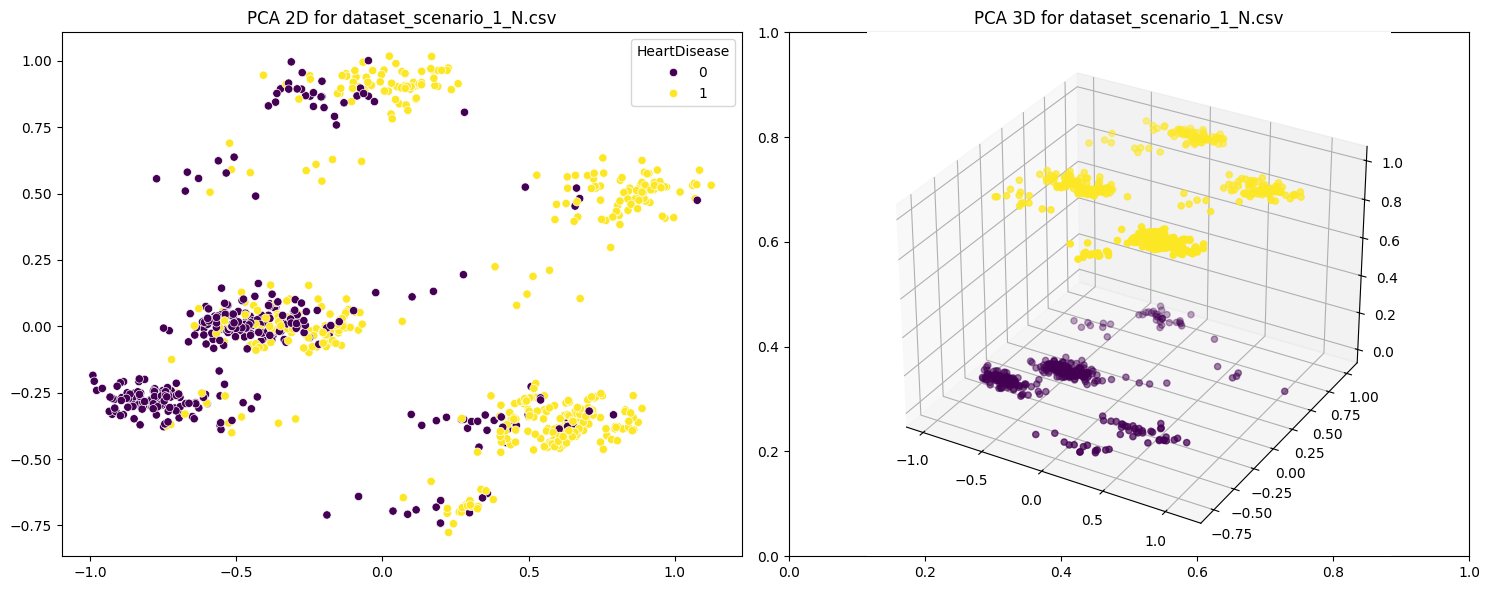

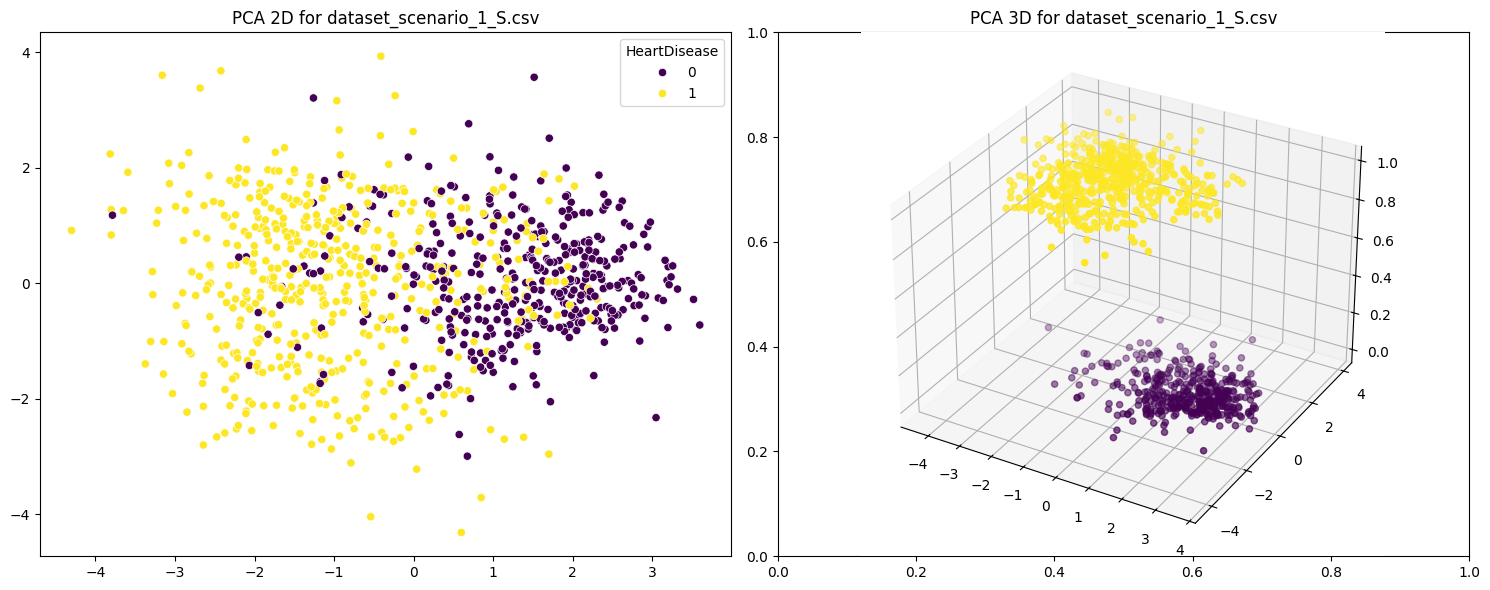

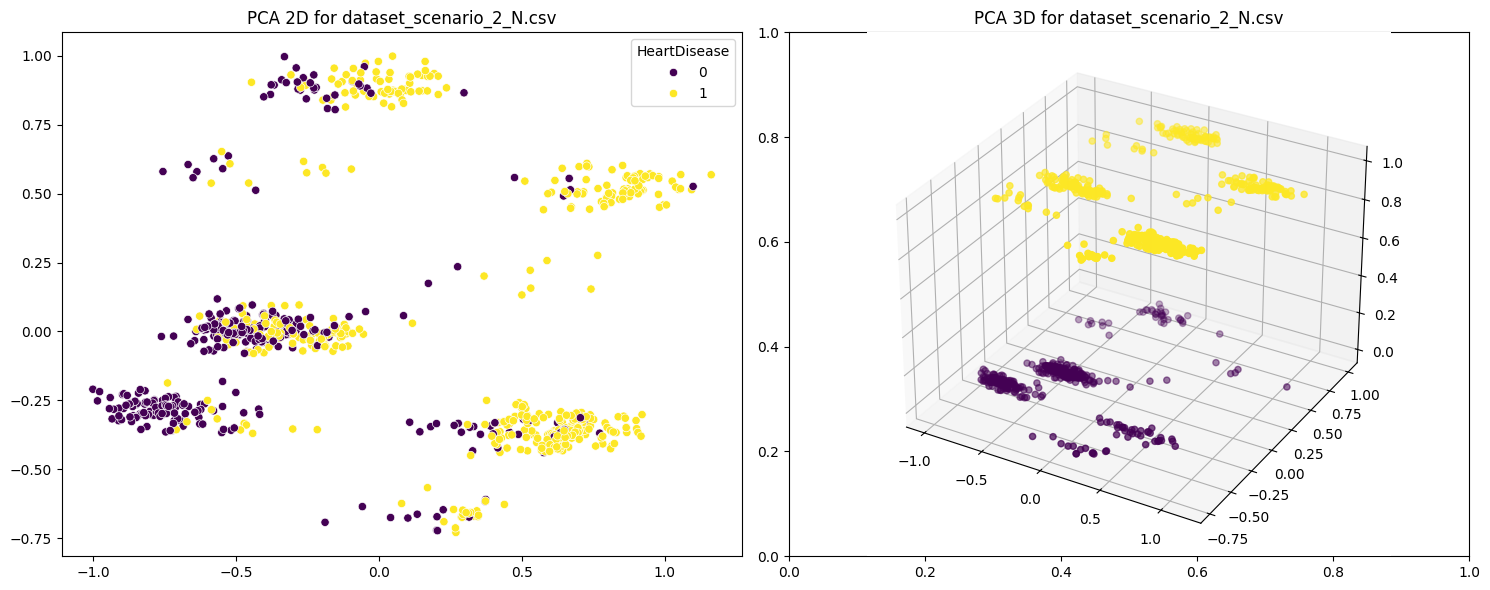

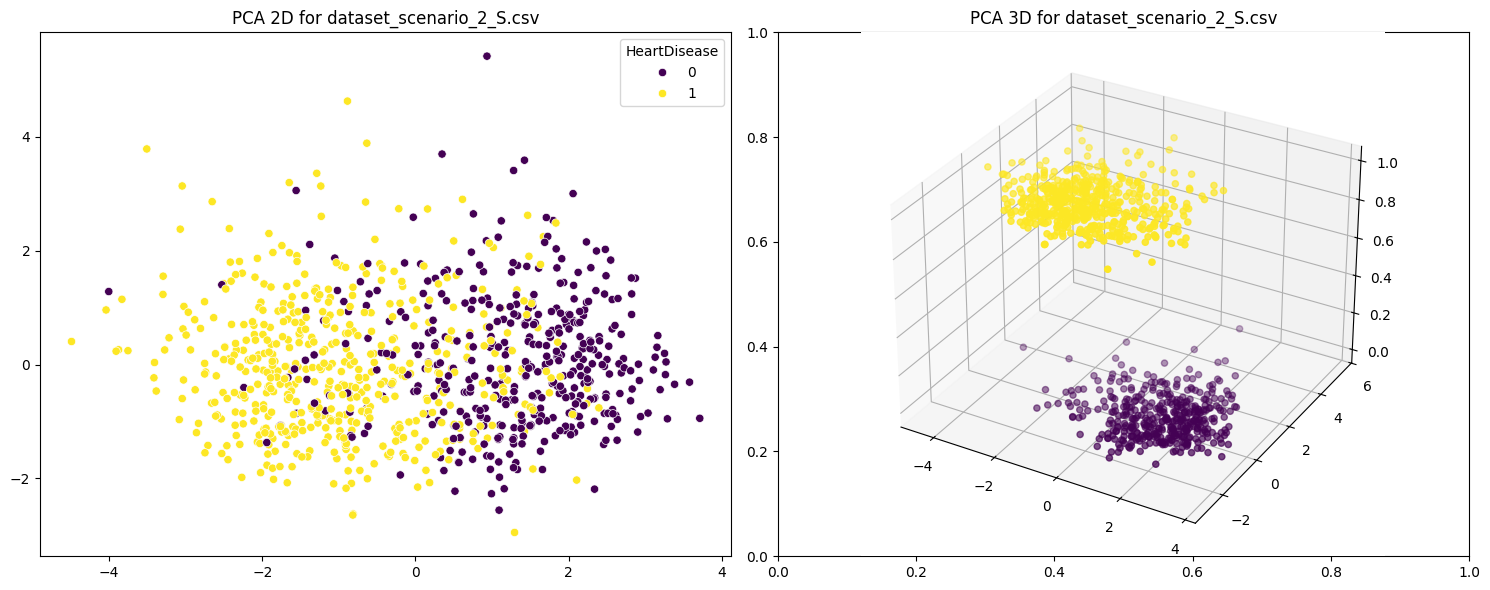

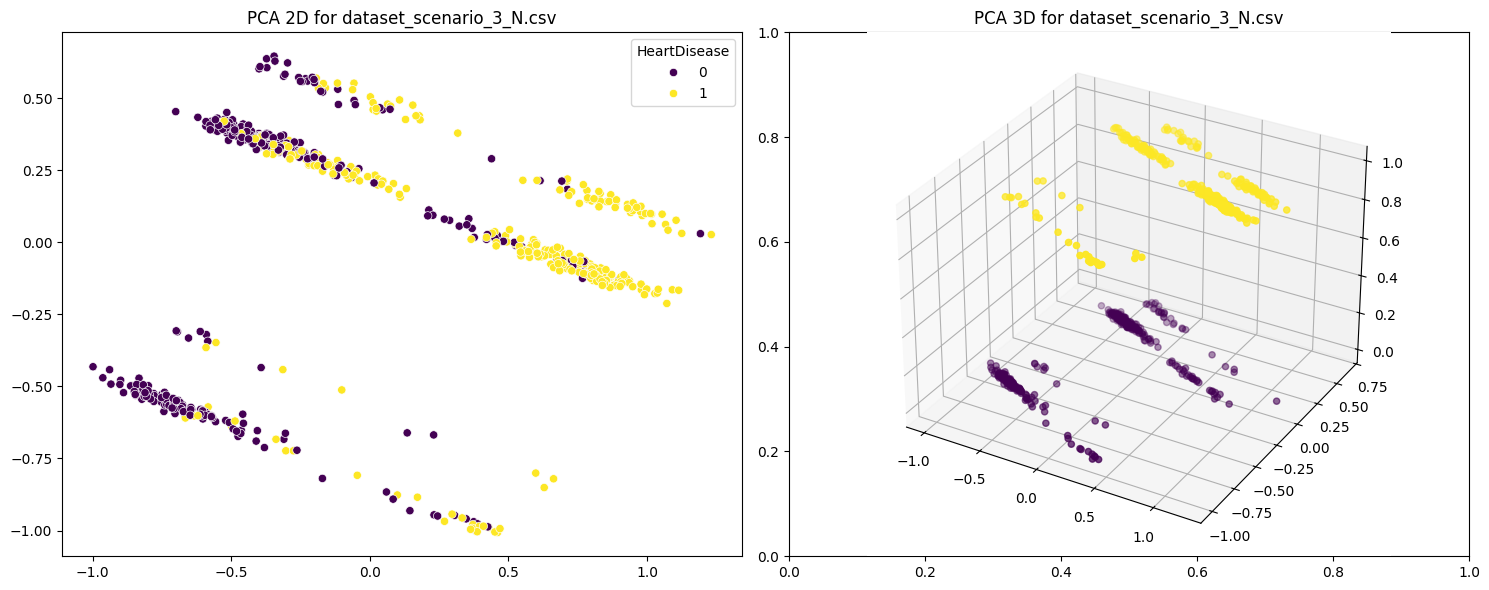

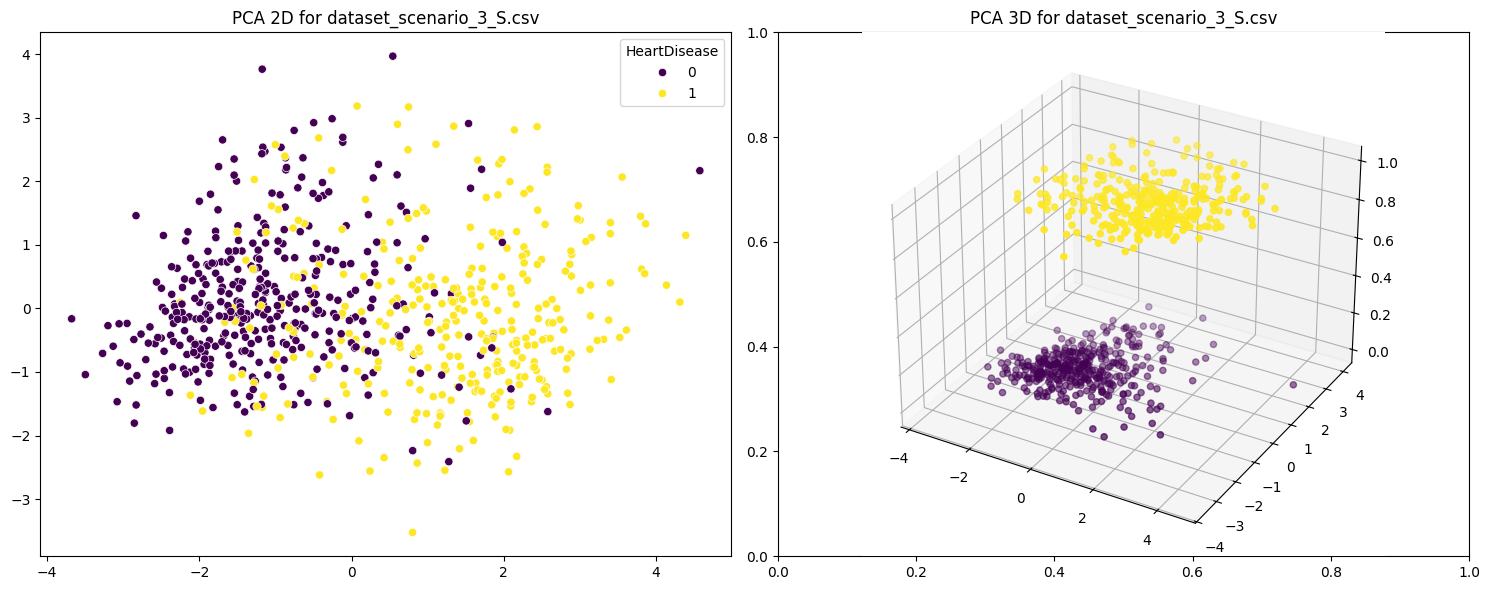

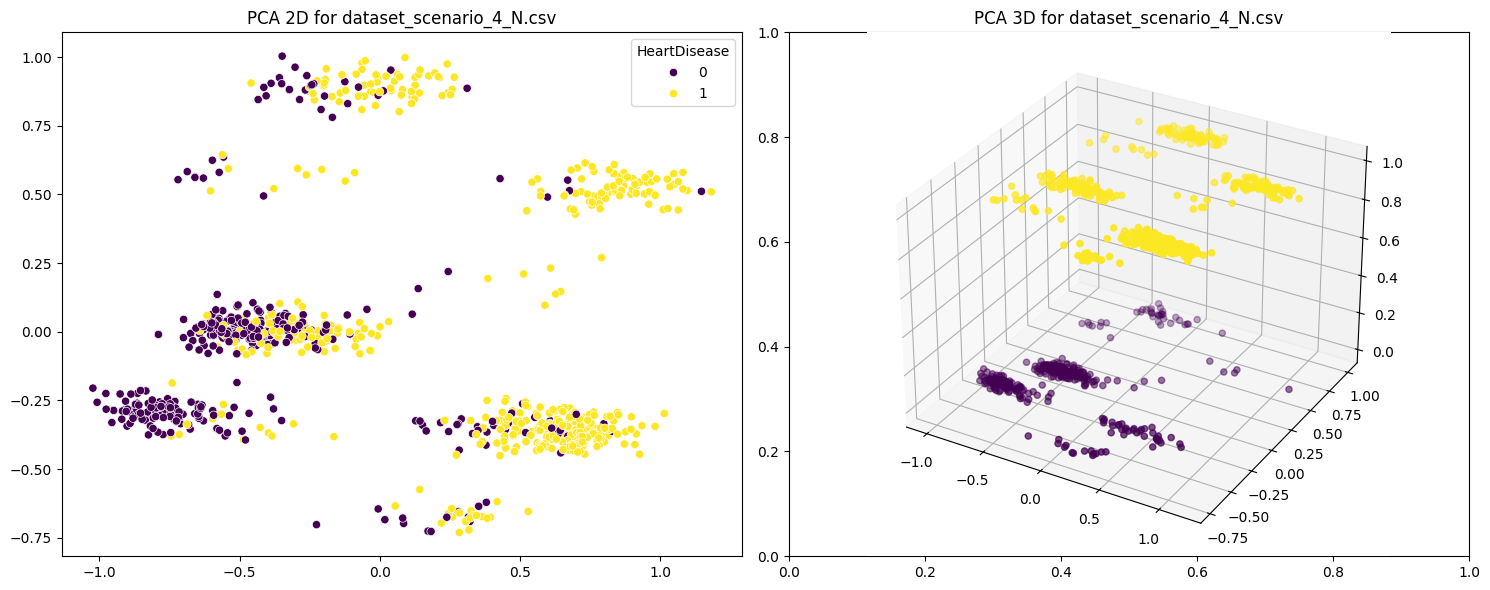

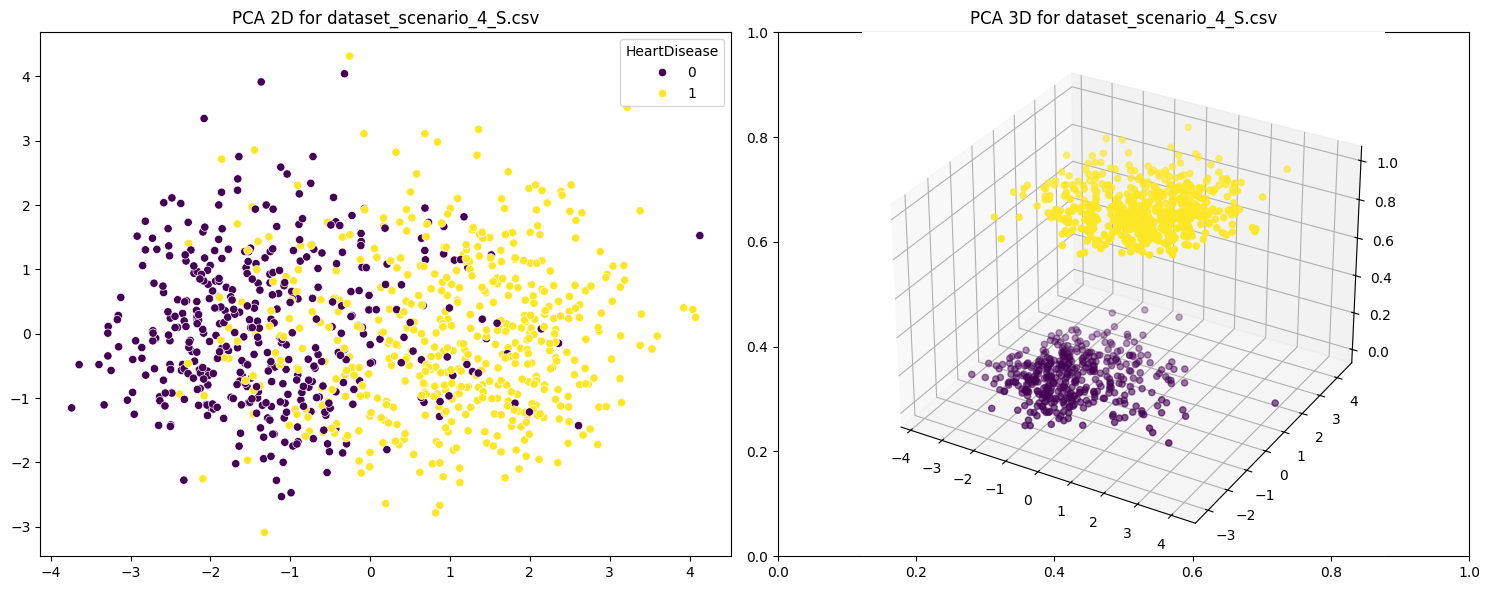

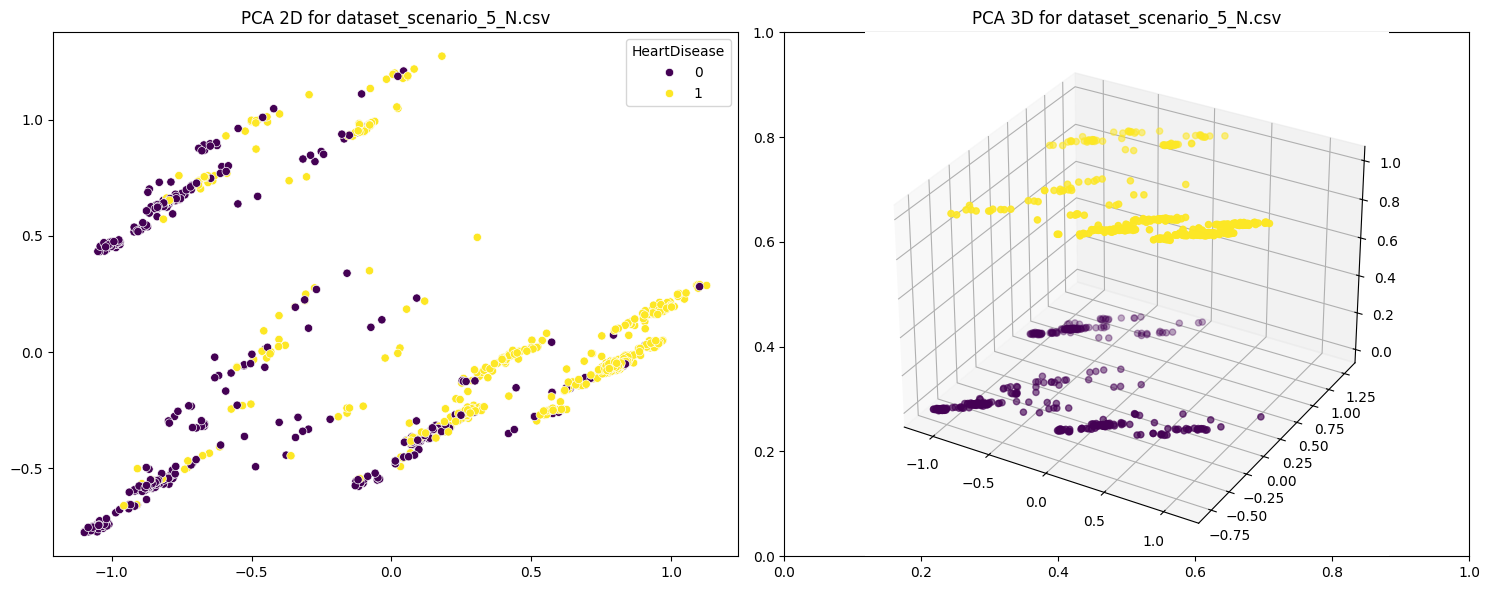

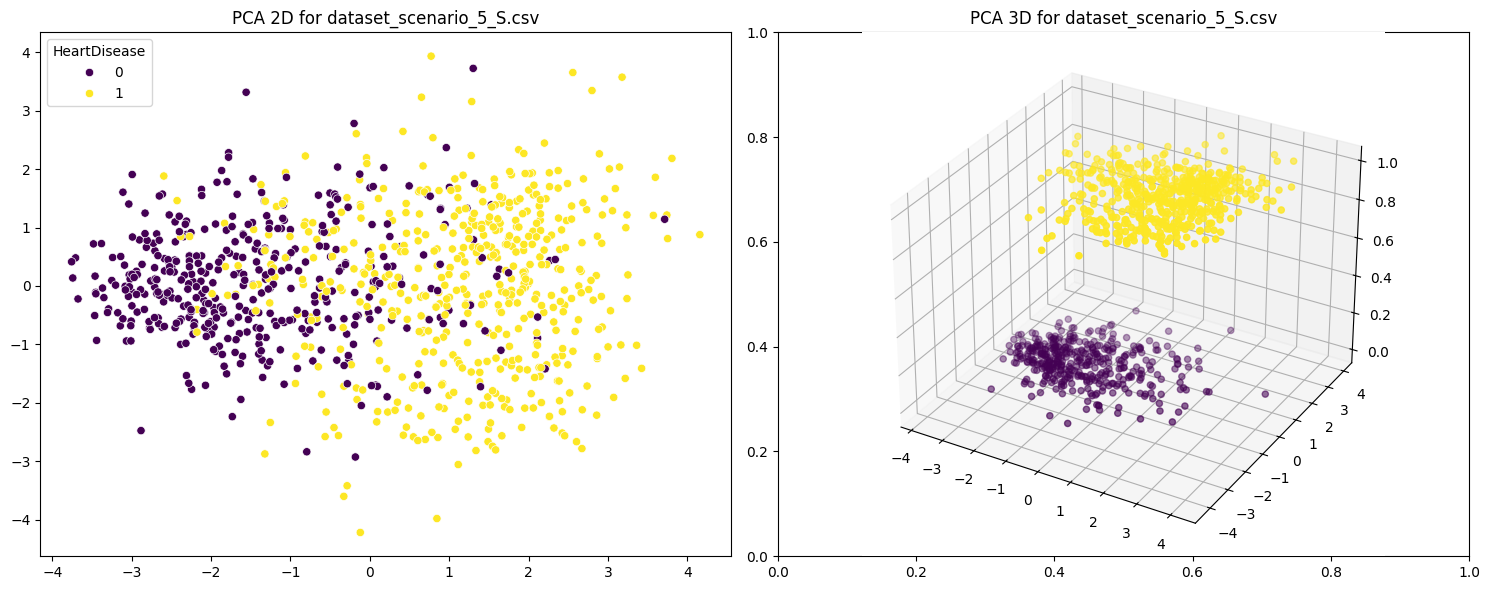

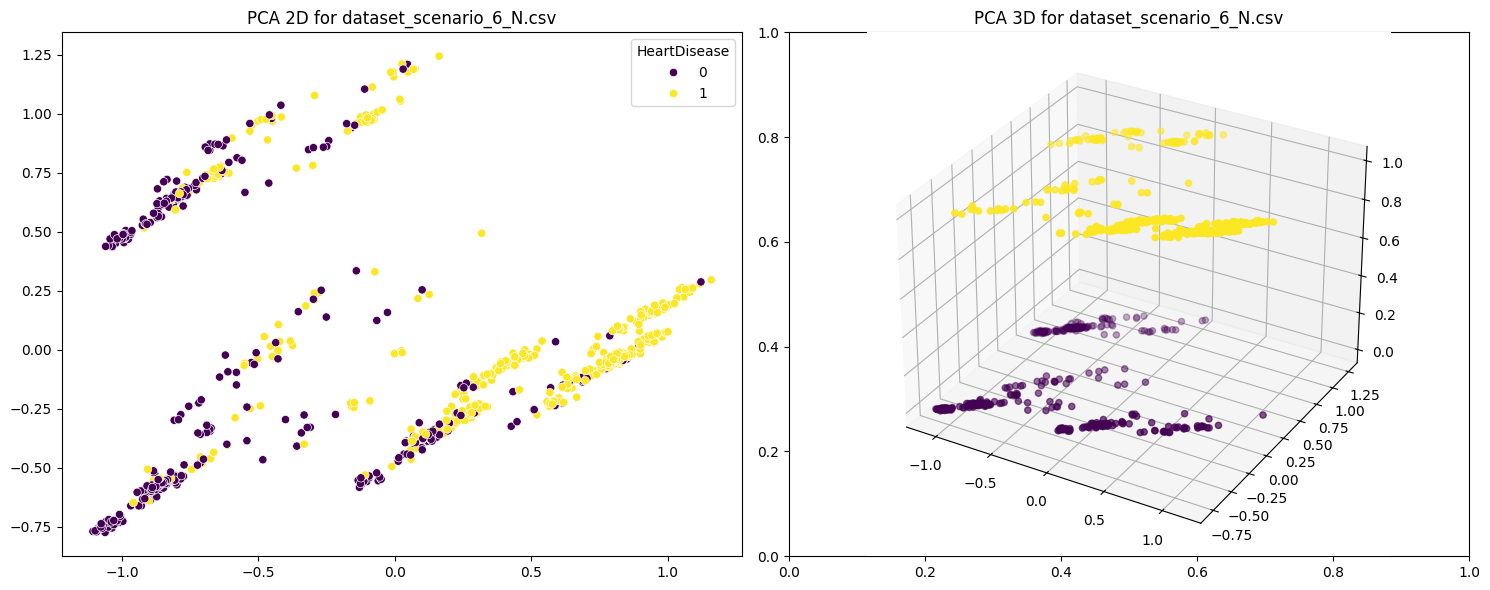

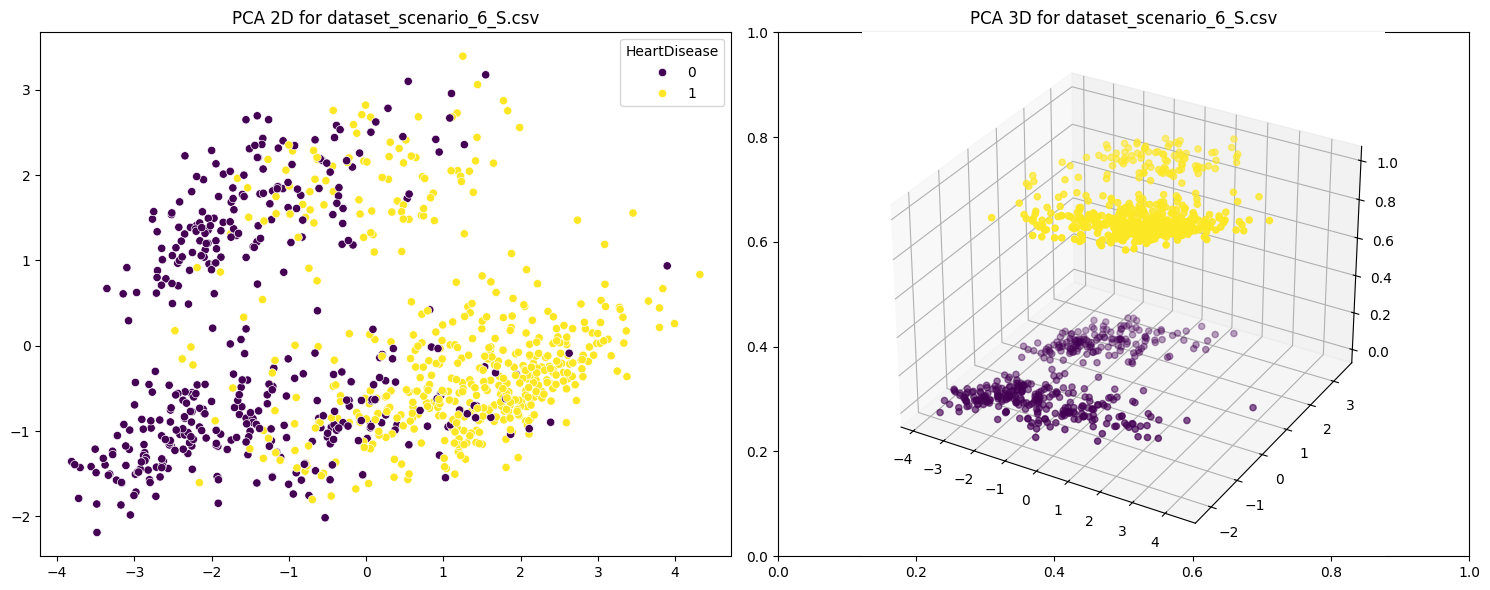

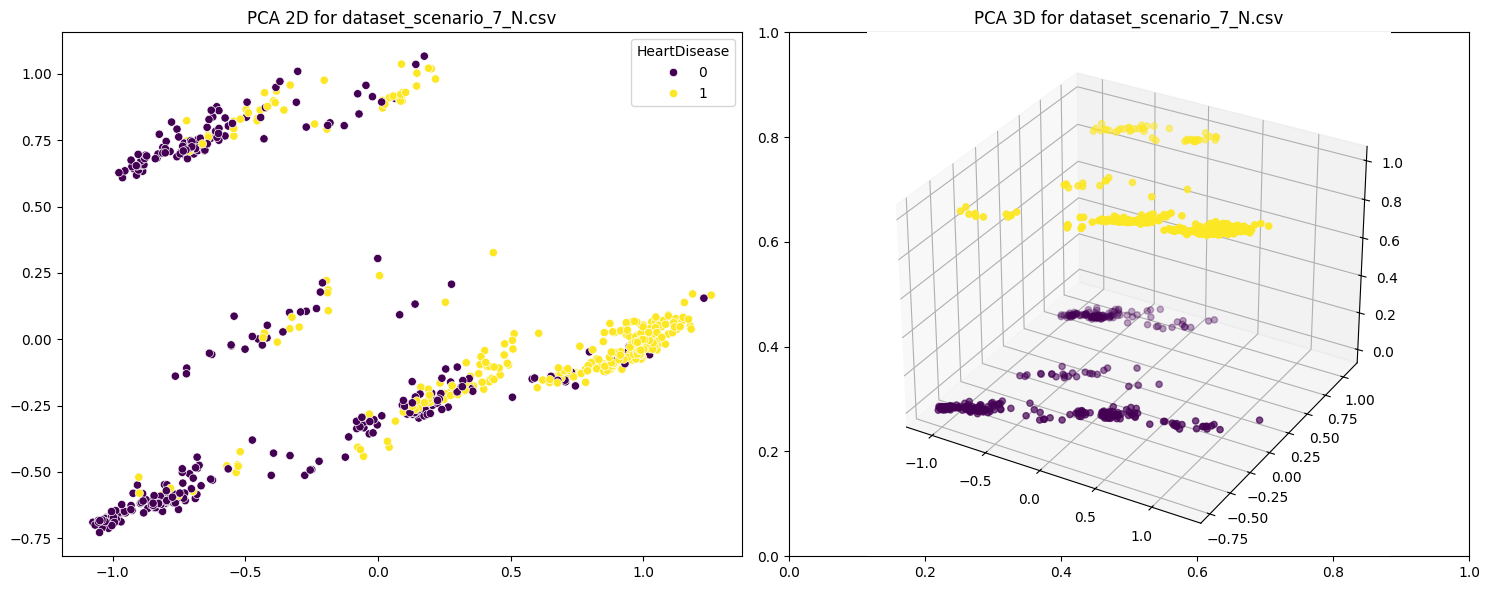

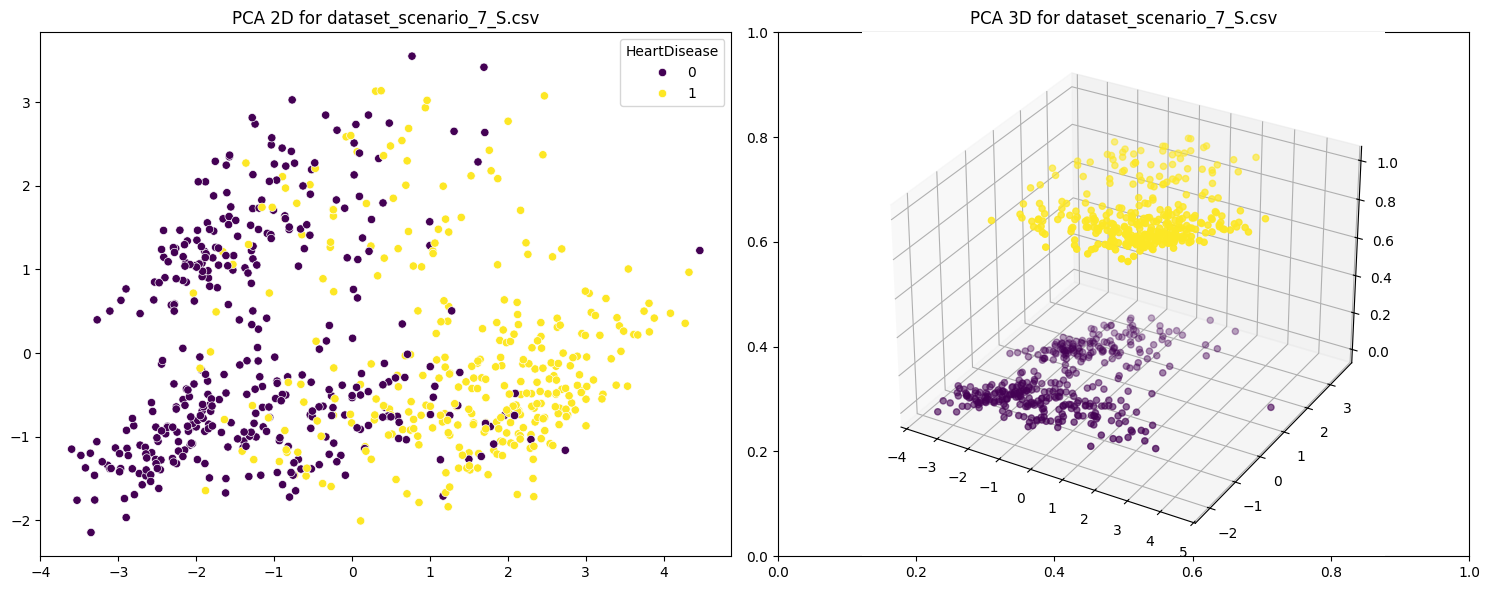

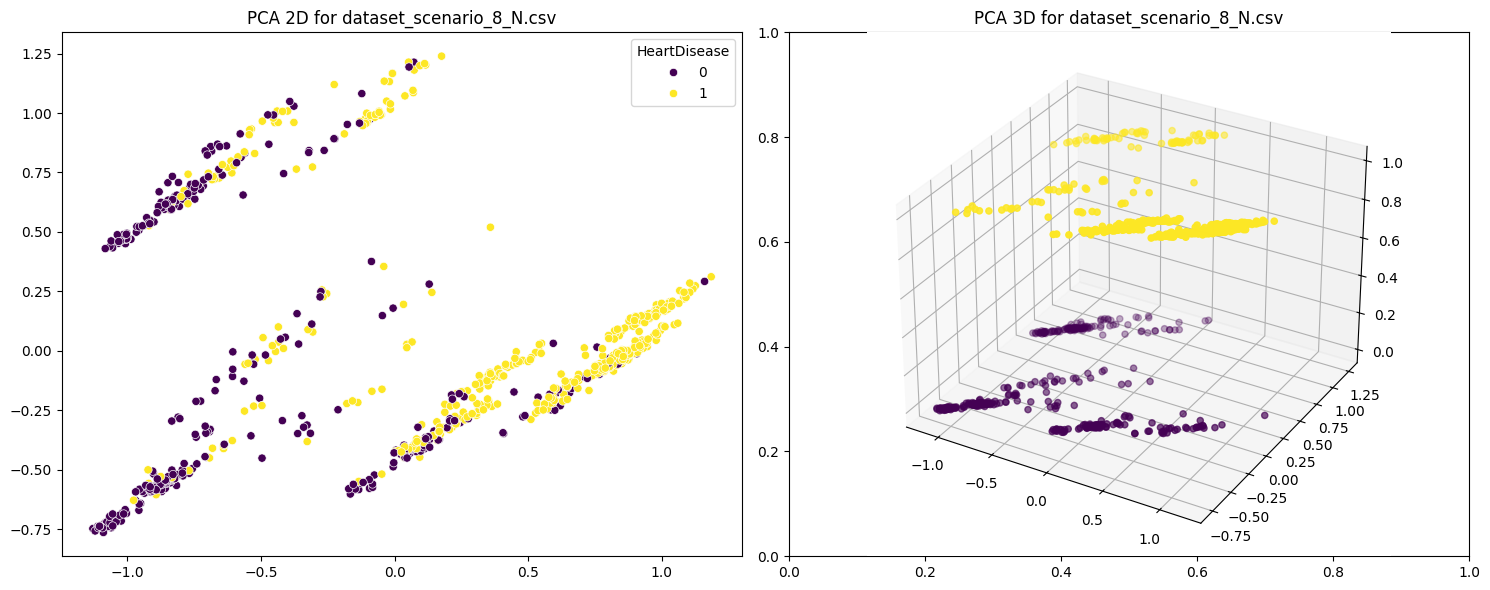

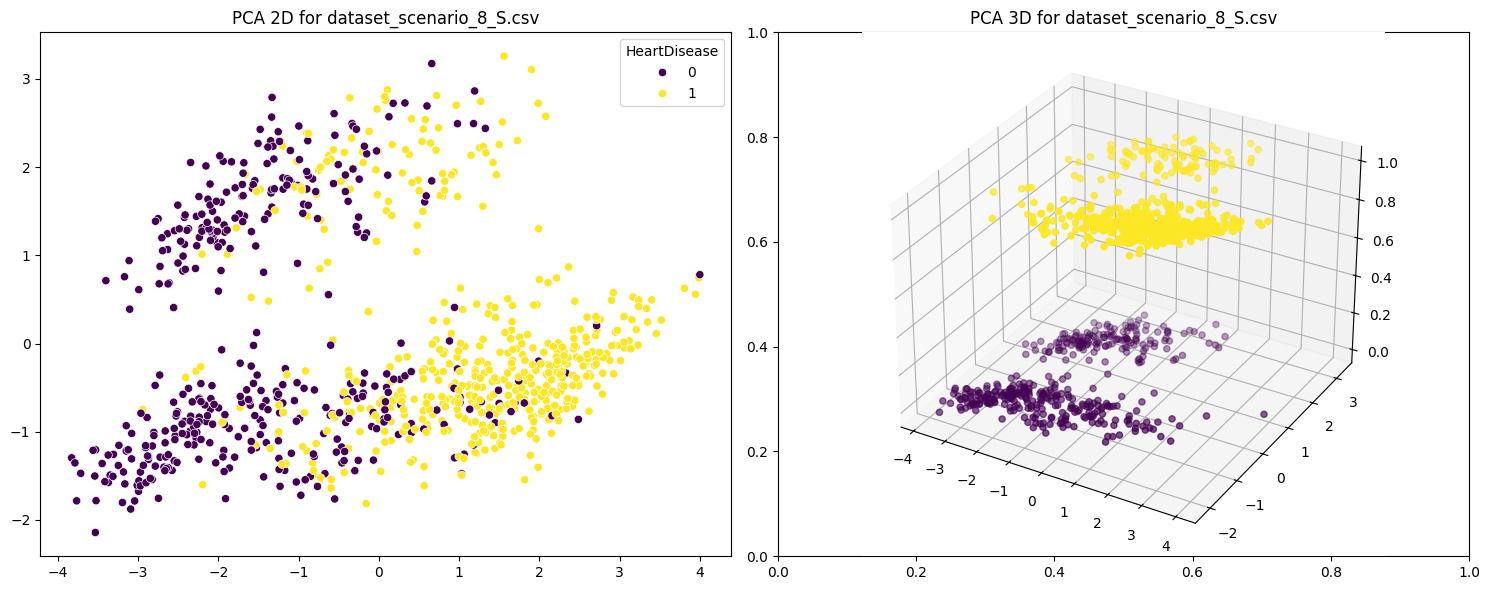

In [56]:
plot_pca_scenarios(list_of_scenarios, three_d=True)